<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase
np.unique(df_reviews['Rating'])

array([0, 1, 2, 3, 4])

In [7]:
df_reviews['Rating'].value_counts(normalize=True)

Rating
4    0.553862
3    0.216775
2    0.124685
1    0.068416
0    0.036262
Name: proportion, dtype: float64

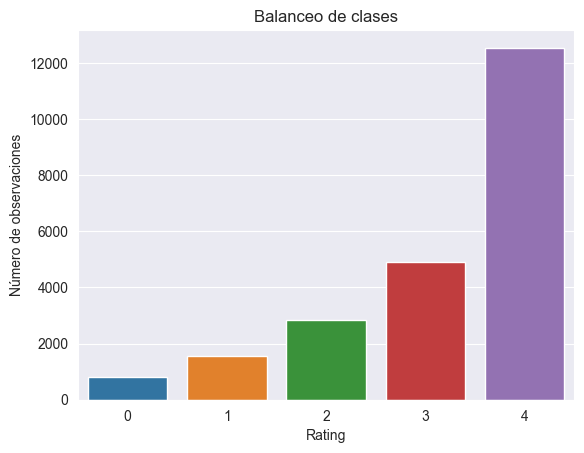

In [8]:
sns.countplot(x='Rating', data=df_reviews)
plt.title("Balanceo de clases")
plt.xlabel("Rating")
plt.ylabel("Número de observaciones");
plt.show()

In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
rating_reviews = df_reviews['Review Text'].values
rating_reviews.shape

(22641,)

In [10]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(rating_reviews)

22641

In [11]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(rating_reviews)

In [12]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [13]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [14]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [15]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [16]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 5000
vocab_size = num_words
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(tokens)

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tokenizer.word_index

In [18]:
# Alumno: Convertir las palabras/tokens a números
rating_reviews_nums = tokenizer.texts_to_sequences(rating_reviews)

In [19]:
# Alumno: Determinar cual es la oración más larga
max(len(rating_reviews_num) for rating_reviews_num in rating_reviews_nums)

116

In [20]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = 116
X = pad_sequences(rating_reviews_nums, padding='pre', maxlen=maxlen)

In [21]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 116)

In [22]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
y = to_categorical(df_reviews['Rating'].values)

In [23]:
y.shape

(22641, 5)

In [24]:
oversampler = RandomOverSampler(sampling_strategy="all")
X, y = oversampler.fit_resample(X, y)

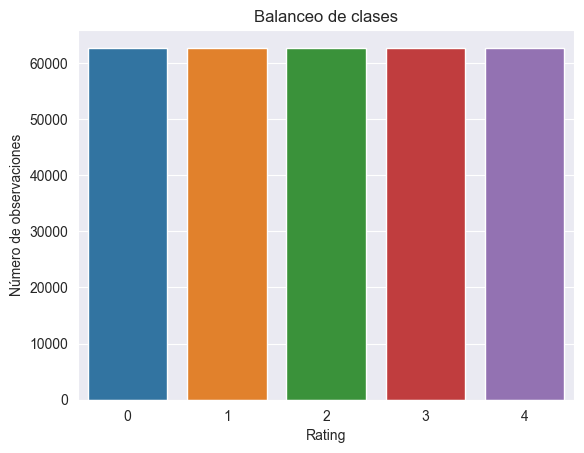

In [25]:
sns.countplot(data=y)#, data=y)
plt.title("Balanceo de clases")
plt.xlabel("Rating")
plt.ylabel("Número de observaciones")
plt.show()

In [26]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Alumno: determinar la dimensiones de entrada y salida
X.shape[1]

116

In [28]:
y.shape[1]

5

### 2 - Entrenar el modelo con Embeddings + LSTM

In [29]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

In [30]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=116))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=5, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 116, 50)           250050    
                                                                 
 lstm (LSTM)                 (None, 116, 64)           29440     
                                                                 
 dropout (Dropout)           (None, 116, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)      

In [31]:
hist = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10


2023-08-17 21:58:43.493002: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1254/1254 [==============================] - 47s 36ms/step - loss: 1.0747 - accuracy: 0.5259 - val_loss: 0.8508 - val_accuracy: 0.6475
Epoch 2/10
1254/1254 [==============================] - 45s 36ms/step - loss: 0.7215 - accuracy: 0.7051 - val_loss: 0.7003 - val_accuracy: 0.7070
Epoch 3/10
1254/1254 [==============================] - 45s 36ms/step - loss: 0.5527 - accuracy: 0.7814 - val_loss: 0.5433 - val_accuracy: 0.7896
Epoch 4/10
1254/1254 [==============================] - 44s 35ms/step - loss: 0.4335 - accuracy: 0.8320 - val_loss: 0.4746 - val_accuracy: 0.8247
Epoch 5/10
1254/1254 [==============================] - 43s 35ms/step - loss: 0.3579 - accuracy: 0.8658 - val_loss: 0.4630 - val_accuracy: 0.8322
Epoch 6/10
1254/1254 [==============================] - 43s 34ms/step - loss: 0.3085 - accuracy: 0.8863 - val_loss: 0.4061 - val_accuracy: 0.8479
Epoch 7/10
1254/1254 [==============================] - 43s 34ms/step - loss: 0.2729 - accuracy: 0.9002 - val_loss: 0.4137 - val_accura

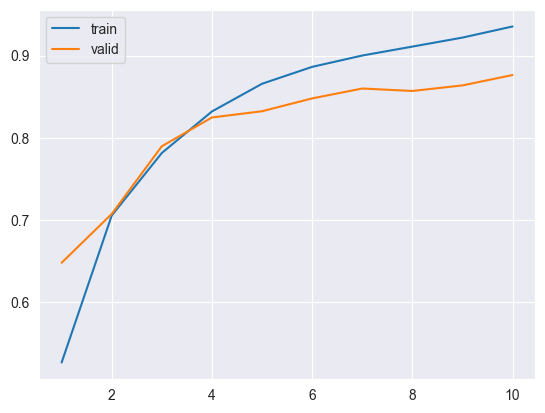

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [33]:
model.evaluate(X_test, y_test)

392/392 [==============================] - 6s 14ms/step - loss: 0.4129 - accuracy: 0.8801


[0.41288915276527405, 0.8801435232162476]